Define constants and path variables

In [269]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from os import path, listdir

BASE_PATH = !pwd
TRAIN_PATH = BASE_PATH[0] + '/train_images/'

MAX_CONTOURS = 30
IMAGE_SIZE = (1600, 900)

# Epsilon ratio for approxPolyDP
# https://docs.opencv.org/3.1.0/dd/d49/tutorial_py_contour_features.html
EPSILON_RATIO = 0.03

Define helper functions for:
- Ploting images
- Listing all image files

In [270]:
def plot_image(img_data):
    plt.imshow(img_data)
    plt.axis('off')  # to hide the axes
    plt.show()

def get_all_files():
    for file_name in [item for item in listdir(TRAIN_PATH) if path.isfile(TRAIN_PATH + item)]:
        yield TRAIN_PATH + file_name

file_list = list(get_all_files())

Main processing class

In [271]:
class ImageFile:
    def __init__(self, file_name):
        self.file_name = file_name
        self.file_data = cv2.imread(file_name)
        
        if (self.file_data.shape[0] > self.file_data.shape[1]):
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[1], IMAGE_SIZE[0]))
        else:
            self.file_data = cv2.resize(self.file_data, (IMAGE_SIZE[0], IMAGE_SIZE[1]))
        
        self.file_data = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2RGB)
    
    """
    Thresholding the file. GaussianBlur is applied to improve thresholding result
    For the bluring operation, we can use either
    - GaussianBlur (faster) or
    - BilateralFilter (better at preserving edges)
    
    For the thresholding operation, we can use either
    - Adaptive threshold (slower) or 
    - OTSU threshold (global min variance)
    
    For the edge detection operation, we can use either
    - Canny
    - Laplacian
    
    1st trial - for general case:
    - Bilateral Filter
    - Otsu threshold
    - Laplacian edge detection
    
    References:
    https://docs.opencv.org/3.3.1/d7/d4d/tutorial_py_thresholding.html
    https://docs.opencv.org/3.3.1/da/d22/tutorial_py_canny.html
    https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html
    """
    def preprocess(self):
        # Grayscaling
        output = cv2.cvtColor(self.file_data, cv2.COLOR_BGR2GRAY)
        
        # Bluring
#         output = cv2.GaussianBlur(output, (3,3), 0)
        output = cv2.GaussianBlur(output, (5,5), 0)
#         output = cv2.bilateralFilter(output,9,75,75)

        # Thresholding
        output = cv2.adaptiveThreshold(output,
            255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
#         thres_level, output = cv2.threshold(output,
#             0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        # Edge detection
#         output = cv2.Canny(output, 100, 200)
        
        # Edge detection - Laplacian
        output = cv2.Laplacian(output, cv2.CV_64F)
        output = np.absolute(output)
        output = np.uint8(output)

        return output

    """
    Generator function for finding card contours
    References:
    https://docs.opencv.org/2.4/doc/tutorials/imgproc/shapedescriptors/find_contours/find_contours.html
    """
    def find_cards(self, preprocessed_img):
        dummy, contours, hierachy = cv2.findContours(preprocessed_img, 
            cv2.RETR_TREE, 
            cv2.CHAIN_APPROX_SIMPLE)
        contour_areas = [cv2.contourArea(cnt) for cnt in contours]
        
        # sort the contours by area
        index_sort = sorted(range(len(contours)), 
            key=lambda idx : contour_areas[idx], 
            reverse=True)
        
        # limit number of contours for processing
        if MAX_CONTOURS is not None and len(index_sort) > MAX_CONTOURS:
            index_sort = index_sort[:MAX_CONTOURS]
            
        for idx in index_sort:
            peri = cv2.arcLength(contours[idx], True)
            approx = cv2.approxPolyDP(contours[idx], EPSILON_RATIO * peri, True)
            
            # pick contours with no parents and 4 corners
            # additionally, limit area of the contour (using contour_areas)
            if len(approx) == 4 and hierachy[0][idx][3] == -1:
#                 yield contours[idx]
                yield approx
    
    """
    Helper function for getting information
    and perspective transform the image
    """
    def get_card_data(self, contour):
        x, y, width, height = cv2.boundingRect(contour)
        
        points = contour.reshape(4, 2)
        
        sum_pts = np.sum(points, axis=1)
        tl = points[np.argmin(sum_pts)]
        br = points[np.argmax(sum_pts)]

        diff_pts = np.diff(points, axis=1)
        tr = points[np.argmin(diff_pts)]
        bl = points[np.argmax(diff_pts)]
        
        # find distances between points
        
        widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
        widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))

        heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
        heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
        
        maxWidth = int(max(widthA, widthB))
        maxHeight = int(max(heightA, heightB))
        
        destination = np.array([
                [0, 0],
                [maxWidth - 1, 0],
                [maxWidth - 1, maxHeight - 1],
                [0, maxHeight - 1]
            ], dtype = 'float32')
        
        rect = np.zeros((4, 2), dtype = "float32")
        rect[0] = tl
        rect[1] = tr
        rect[2] = br
        rect[3] = bl
        
        perspective_transform = cv2.getPerspectiveTransform(rect, destination)
        
        warped_img = cv2.warpPerspective(self.file_data, perspective_transform, (maxWidth, maxHeight))
        
        # checks if card is horizontal and needs to be rotated
#         print(maxWidth, maxHeight)
        if maxWidth > 1.1 * maxHeight:
            warped_img = self.rotate_image(warped_img, 90)
        
        return {
            'x': x,
            'y': y,
            'img': warped_img
        }
    
    """
    Helper function for rotating the image
    """
    def rotate_image(self, img_data, angle):
        rows, cols, channels = img_data.shape
        (cX, cY) = (cols // 2, rows // 2)
        
        rotation_matrix = cv2.getRotationMatrix2D((cX, cY), angle, 1)
        
        cos = np.abs(rotation_matrix[0, 0])
        sin = np.abs(rotation_matrix[0, 1])
        nW = int((rows * sin) + (cols * cos))
        nH = int((rows * cos) + (cols * sin))
        rotation_matrix[0, 2] += (nW / 2) - cX
        rotation_matrix[1, 2] += (nH / 2) - cY
        
        return cv2.warpAffine(img_data, rotation_matrix, (nW, nH))
    
    def extract_cards(self, resize=None):
        img_data = self.preprocess()
        contours = self.find_cards(img_data)
        
        for contour in contours:
            data = self.get_card_data(contour)
            if resize is not None:
                data['img'] = cv2.resize(data['img'], resize)
            yield data

Display the preprocessing results

(1600, 900)


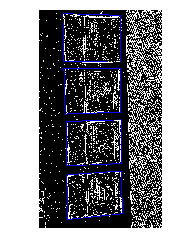

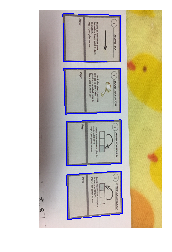

In [272]:
# img_file = ImageFile(file_list[1])
# img_file = ImageFile(TRAIN_PATH + 'DSC_1166.JPG')
img_file = ImageFile(TRAIN_PATH + 'IMG_4010.JPG')
# img_file = ImageFile(TRAIN_PATH + 'card25.JPG')
img_data = img_file.preprocess()

# Dimensions of the image
print(np.shape(img_data))

contours = list(img_file.find_cards(img_data))

img_data = np.stack((img_data,)*3, axis=-1)

if len(contours) > 0:
    cv2.drawContours(img_data, contours, -1, (0, 0, 255), 5)
# Plot the preprocessed file
plot_image(img_data)

# Draw the original image with contours
img_data = img_file.file_data.copy()

if len(contours) > 0:
    cv2.drawContours(img_data, contours, -1, (0, 0, 255), 5)

plot_image(img_data)

- Perspective transform using the extracted contours.
- Rotate the extracted image if necessary

Rect coordinates: (174, 26)


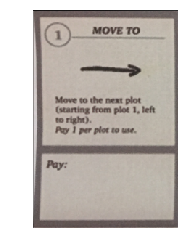

Rect coordinates: (182, 429)


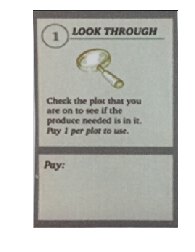

Rect coordinates: (198, 806)


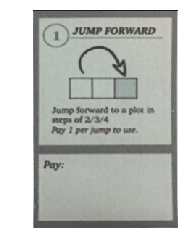

Rect coordinates: (203, 1181)


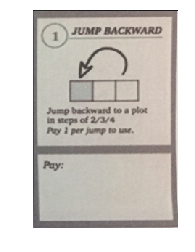

In [273]:
for data in list(img_file.extract_cards(resize=(200, 300))):
    print('Rect coordinates: %s' % str((data['x'], data['y'])))
    plot_image(data['img'])